# The Spectral Bias

This code is very similar to (https://github.com/nasimrahaman/SpectralBias). 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from argparse import Namespace
from functools import reduce

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

sns.set(rc={'figure.figsize':(5,5)}, style="whitegrid", font_scale=1.0)


## Data Generation

The code for generating the dataset and evaluating FFT. 

In [4]:
def make_phased_waves(opt):
    t = np.arange(0, 1, 1./opt.N)
    if opt.A is None:
        yt = reduce(lambda a, b: a + b, 
                    [np.sin(2 * np.pi * ki * t + 2 * np.pi * phi) for ki, phi in zip(opt.K, opt.PHI)])
    else:
        yt = reduce(lambda a, b: a + b, 
                    [Ai * np.sin(2 * np.pi * ki * t + 2 * np.pi * phi) for ki, Ai, phi in zip(opt.K, opt.A, opt.PHI)])
    return t, yt

def fft(opt, yt):
    n = len(yt) # length of the signal
    k = np.arange(n)
    T = n/opt.N
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range
    # -------------
    FFTYT = np.fft.fft(yt)/n # fft computing and normalization
    FFTYT = FFTYT[range(n//2)]
    fftyt = abs(FFTYT)
    return frq, fftyt

def to_torch_dataset_1d(opt, t, yt):
    t = torch.from_numpy(t).view(-1, 1).float()
    yt = torch.from_numpy(yt).view(-1, 1).float()
    if opt.CUDA:
        t = t.cuda()
        yt = yt.cuda()
    return t, yt

## Model Training

In [5]:
class Lambda(nn.Module):
    def __init__(self, lambd):
        super(Lambda, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)
    
def make_model(opt, sig, act='RELU'):
    layers = []
    layers.append(nn.Linear(opt.INP_DIM, opt.WIDTH))
    layers.append(Lambda(lambda x: x + torch.randn_like(x)*sig))
    for _ in range(opt.DEPTH - 2): 
        layers.append(nn.Linear(opt.WIDTH, opt.WIDTH))
        layers.append(nn.ReLU())
        layers.append(Lambda(lambda x: x + torch.randn_like(x)*sig))
    layers.extend([nn.Linear(opt.WIDTH, opt.OUT_DIM)])
    model = nn.Sequential(*layers)
    if opt.CUDA:
        model = model.cuda()
    return model

In [184]:
from numpy import linalg as LA

def power_iteration(A, num_simulations=10):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    if hasattr(A, 'data'): 
        A = A.data
    b_k = A.new(A.shape[1], 1).normal_()
    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = A @ b_k
        # calculate the norm
        b_k1_norm = torch.norm(b_k1)
        # re normalize the vector
        b_k = b_k1 / b_k1_norm
    return ((b_k.t() @ A @ b_k) / b_k.t() @ b_k).squeeze().abs()
    # return torch.dot(torch.dot(b_k.t(), A), b_k) / torch.dot(b_k.t(), b_k)

def spectral_norm(model): 
    norms = []
    for layer in model: 
        if isinstance(layer, nn.Linear):
            if layer.in_features == layer.out_features: 
                norms.append(power_iteration(layer.weight).cpu().numpy())
            elif layer.in_features == 1 or layer.out_features == 1: 
                norms.append(torch.norm(layer.weight.data))
    return norms

def eigen_weights(model): 
    norms = []
    for layer in model: 
        if isinstance(layer, nn.Linear):
            if layer.in_features == layer.out_features: 
                lamb, v = LA.eig(layer.weight.cpu().detach().numpy())
                norms.append(lamb)
    return norms

def trace_weights(model): 
    norms = []
    for layer in model: 
        if isinstance(layer, nn.Linear):
            if layer.in_features == layer.out_features: 
                lamb = np.trace(layer.weight.cpu().detach().numpy())
                norms.append(lamb)
    return norms

def spectral_norm_acts(acts): 
    norms = []
    for a in acts: 
        norms.append(torch.norm(a.detach()).numpy())
    return norms

In [298]:

def calc_layer_layer_der(acts): 
    layer_to_layer_der = list()
    for i, a in enumerate(acts[:-1]): 
        jacobian = list()
        B, n = a.shape
        for j in range(acts[i+1].shape[1]):
            v = torch.zeros_like(acts[i+1])
            v[:, j] = 1.
            dy_i_dx = torch.autograd.grad(acts[i+1],
                                          a,
                                          grad_outputs=v,
                                          retain_graph=True,
                                          create_graph=True,
                                          allow_unused=True)[0]  # shape [B, N]
            jacobian.append(dy_i_dx)

        jacobian = torch.stack(jacobian, dim=2).view(B, -1, n)
        layer_to_layer_der.append(torch.norm(jacobian, dim=(1, 2)).mean(dim=0).cpu().detach().numpy())
    return layer_to_layer_der
            
def train_model(opt, model, input_, target, sig):
    # Build loss
    loss_fn = nn.MSELoss()
    # Build optim
    optim = torch.optim.Adam(model.parameters(), lr=opt.LR)
    # Rec
    frames = []
    model.train()
    # To cuda
    if opt.CUDA:
        input_ = input_.cuda()
        target = target.cuda()
    # Loop! 
    for iter_num in range(opt.NUM_ITER):
        if iter_num % (opt.NUM_ITER // 100) == 0: 
            print(">", end='')
        x = input_
        yt = target.view(-1, opt.OUT_DIM)
        optim.zero_grad()
        acts = list()
        for layer in model:
            x = layer(x)
            if isinstance(layer, nn.ReLU):
                acts.append(x)
        y = x
        if opt.exp_reg: 
            x.requires_grad_(True)
            v = torch.ones_like(y)
            loss = loss_fn(y, yt)
#             v[:, 0] = 1.
            for i, a in enumerate(acts[:-1]): 
                dy_i_dx = torch.autograd.grad(y,
                                                  a,
                                                  grad_outputs=v,
                                                  retain_graph=True,
                                                  create_graph=True,
                                                  allow_unused=True)[0]  # shape [B, N]
                exp_reg = (sig**2)*(dy_i_dx**2).sum(axis=-1).mean()
                loss += exp_reg
        else: 
            loss = loss_fn(y, yt)
        
        
        if iter_num % opt.REC_FRQ == 0: 
            # Measure spectral norm
            layer_to_layer_der = calc_layer_layer_der(acts)
            frames.append(Namespace(iter_num=iter_num, 
                                    prediction=y.data.cpu().numpy(), 
                                    spectral_norm_acts=spectral_norm_acts(acts),
                                    loss=loss.item(), 
                                    spectral_norms=spectral_norm(model),
                                    trace_w=trace_weights(model),
                                    layer_to_layer_der=layer_to_layer_der))
            
        loss.backward()
        optim.step()
    # Done
    model.eval()
    return frames


def calc_exp_regs(opt, input_, target, sig):
    # To cuda
    if opt.CUDA:
        input_ = input_.cuda()
        target = target.cuda()
    # Loop! 
    exp_regs = []
    model = make_model(opt, 0)
    for iter_num in range(opt.NUM_ITER):
        if iter_num % (opt.NUM_ITER // 100) == 0: 
            print(">", end='')
        x = input_
        yt = target.view(-1, opt.OUT_DIM)
        acts = list()
        x.requires_grad_(True)
        for layer in no_noise_model:
            x = layer(x)
            if isinstance(layer, nn.ReLU):
                acts.append(x)
        for i, a in enumerate(acts[:-1]): 
            dy_i_dx = torch.autograd.grad(x,
                                          a,
                                          grad_outputs=torch.ones_like(y),
                                          retain_graph=True,
                                          create_graph=True,
                                          allow_unused=True)[0]  # shape [B, N]
            exp_regs.append((sig**2)*(dy_i_dx**2).sum(axis=-1).mean())
    return exp_regs

def calc_residuals(opt, input_, target, sig):
    # Build loss
    loss_fn = nn.MSELoss()
    # Build optim
    optim = torch.optim.Adam(model.parameters(), lr=opt.LR)
    # Rec
    frames = []
    model.train()
    # To cuda
    if opt.CUDA:
        input_ = input_.cuda()
        target = target.cuda()
    # Loop! 
    exp_regs = []
    model = make_model(opt, sig)
    for iter_num in range(opt.NUM_ITER):
        if iter_num % (opt.NUM_ITER // 100) == 0: 
            print(">", end='')
        x = input_
        yt = target.view(-1, opt.OUT_DIM)
        optim.zero_grad()
        acts = list()
        x.requires_grad_(True)
        for layer in no_noise_model:
            x = layer(x)
            if isinstance(layer, nn.ReLU):
                acts.append(x)
        y = x
        v = torch.ones_like(y)
        mse_loss = loss_fn(y, yt)
#             v[:, 0] = 1.
        for i, a in enumerate(acts[:-1]): 
            dy_i_dx = torch.autograd.grad(y,
                                          a,
                                          grad_outputs=v,
                                          retain_graph=True,
                                          create_graph=True,
                                          allow_unused=True)[0]  # shape [B, N]
            exp_regs.append((sig**2)*(dy_i_dx**2).sum(axis=-1).mean())
    return residuals

## Visualization

In [299]:
def plot_inferred_wave(opt, x, y, yinf):
    fig, ax = plt.subplots(1, 1)
    ax.set_title("Function")
    ax.plot(x, y, label='Target')
    ax.plot(x, yinf, label='Learnt')
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.legend()
    plt.show()
    
def plot_wave_and_spectrum(opt, x, yox):
    # Btw, "yox" --> "y of x"
    # Compute fft
    k, yok = fft(opt, yox)
    # Plot
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.set_title("Function")
    ax0.plot(x, yox)
    ax0.set_xlabel("x")
    ax0.set_ylabel("f(x)")
    ax1.set_title("FT of Function")
    ax1.plot(k, yok)
    ax1.set_xlabel("k")
    ax1.set_ylabel("f(k)")
    plt.show()

In [332]:
def compute_spectra(opt, frames): 
    # Make array for heatmap
    dynamics = []
    xticks = []
    for iframe, frame in enumerate(frames): 
        # Compute fft of prediction
        frq, yfft = fft(opt, frame.prediction.squeeze())
        dynamics.append(yfft)
        xticks.append(frame.iter_num)
    return np.array(frq), np.array(dynamics), np.array(xticks)

def plot_spectral_dynamics(opt, all_frames):
    all_dynamics = []
    # Compute spectra for all frames
    for frames in all_frames: 
        frq, dynamics, xticks = compute_spectra(opt, frames)
        all_dynamics.append(dynamics)
    # Average dynamics over multiple frames
    # mean_dynamics.shape = (num_iterations, num_frequencies)
    mean_dynamics = np.array(all_dynamics).mean(0)
    # Select the frequencies which are present in the target spectrum
    freq_selected = mean_dynamics[:, np.sum(frq.reshape(-1, 1) == np.array(opt.K).reshape(1, -1), 
                                            axis=-1, dtype='bool')]
    # Normalize by the amplitude. Remember to account for the fact that the measured spectra 
    # are single-sided (positive freqs), so multiply by 2 accordingly
    norm_dynamics = 2 * freq_selected / np.array(opt.A).reshape(1, -1)
    # Plot heatmap
    plt.figure(figsize=(7, 6))
    # plt.title("Evolution of Frequency Spectrum (Increasing Amplitudes)")
    sns.heatmap(norm_dynamics[::-1], 
                xticklabels=opt.K, 
                yticklabels=[(frame.iter_num if frame.iter_num % 10000 == 0 else '') 
                             for _, frame in zip(range(norm_dynamics.shape[0]), frames)][::-1], 
                vmin=0., vmax=1., 
                cmap=sns.cubehelix_palette(8, start=.5, rot=-.75, reverse=True, as_cmap=True))
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Training Iteration")
    plt.show()

def plot_multiple_spectral_norms(all_frames):
    iter_nums = np.array([frame.iter_num for frame in all_frames[0]])
    norms = np.array([np.array(list(zip(*[frame.layer_to_layer_der for frame in frames]))).squeeze() for frames in all_frames])
    print(norms)
    means = norms.mean(0)
    stds = norms.std(0)
    plt.xlabel("Training Iteration")
    plt.ylabel(r'$|| \tilde{\mathbf{W}}_k||_2^2$')
    for layer_num, (mean_curve, std_curve) in enumerate(zip(means, stds)): 
        p = plt.plot(iter_nums, mean_curve, label=f'Layer {layer_num + 1}')
        plt.fill_between(iter_nums, mean_curve + std_curve, mean_curve - std_curve, color=p[0].get_color(), alpha=0.15)
    plt.legend()
    plt.show()

## Play

In [301]:
opt = Namespace()

In [307]:
# Data Generation
opt.N = 200
opt.K = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
opt.A = [1 for _ in opt.K]
opt.PHI = [np.random.rand() for _ in opt.K]
# Model parameters
opt.INP_DIM = 1
opt.OUT_DIM = 1
opt.WIDTH = 256
opt.DEPTH = 6
# Training
# --- Switch exp_reg on and off to approximate GNIs as R in the main paper. 
opt.exp_reg=False
opt.CUDA = False
opt.NUM_ITER = 60000
opt.REC_FRQ = 100
opt.LR = 0.0003

### Plot the Functions

... as a sanity check. 

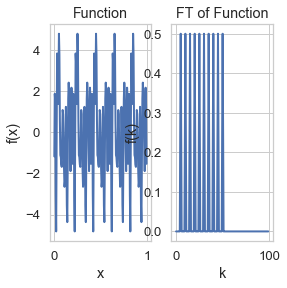

In [308]:
x, y = make_phased_waves(opt)
plot_wave_and_spectrum(opt, x, y)

Note that we only plot the positive frequencies, which is why the peaks in the spectrum are at $0.5$ (half the power is in the negative frequencies). 

### Train the Model

In [309]:
def go(opt, repeats=10, sig=0):
    all_frames = []
    for _ in range(repeats): 
        # Sample random phase
        opt.PHI = [np.random.rand() for _ in opt.K]
        # Generate data
        x, y = to_torch_dataset_1d(opt, *make_phased_waves(opt))
        # Make model
        model = make_model(opt, sig)
       
        # Train
        frames = train_model(opt, model, x, y, sig)
        all_frames.append(frames)
        yinf = model(x)
        plot_inferred_wave(opt, x.detach().cpu().numpy(), y.detach().cpu().numpy(), yinf.detach().cpu().numpy())
        
        print('', end='\n')
    return all_frames

#### Case 1: All Frequencies with Same Amplitude

In [310]:
opt.K = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
opt.A = [1 for _ in opt.K]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

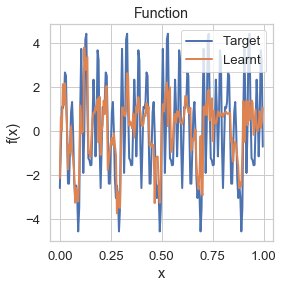


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

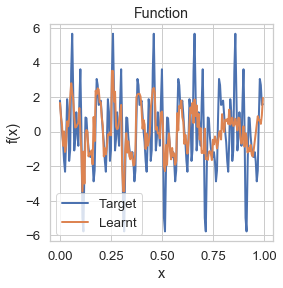


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

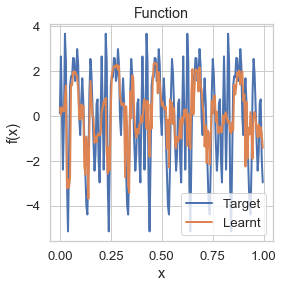


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

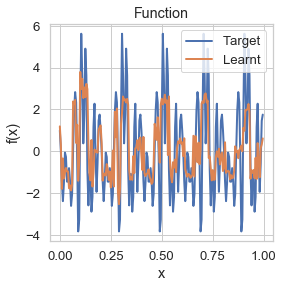


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

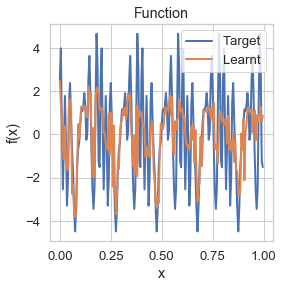

In [311]:
# Add noise with variance 0.1
eq_amp_frames_noise = go(opt, 5, 0.1)

In [312]:
import pickle 

with open('noise.pickle', 'wb') as handle:
    pickle.dump(eq_amp_frames_noise, handle, protocol=pickle.HIGHEST_PROTOCOL)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

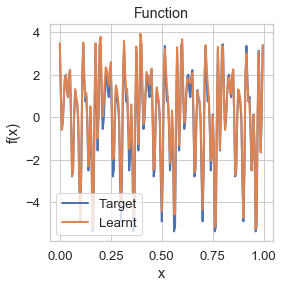


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

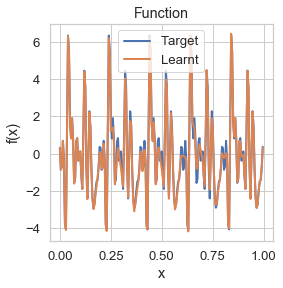


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

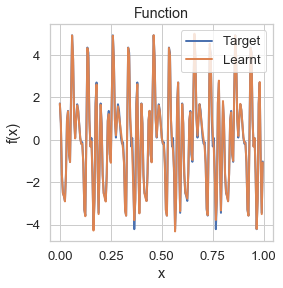


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

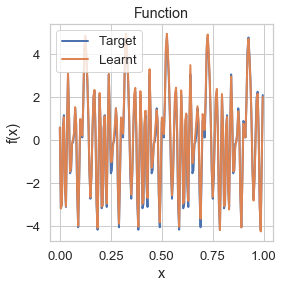


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

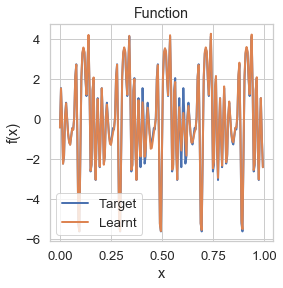

In [313]:
# Baseline with no noise

eq_amp_frames = go(opt, 5, 0)

In [314]:
import pickle 

with open('nonoise.pickle', 'wb') as handle:
    pickle.dump(eq_amp_frames, handle, protocol=pickle.HIGHEST_PROTOCOL)

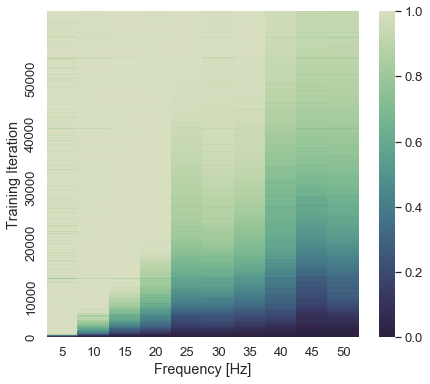

In [315]:
plot_spectral_dynamics(opt, eq_amp_frames)

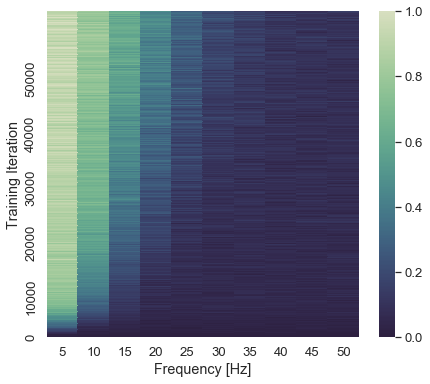

In [316]:
plot_spectral_dynamics(opt, eq_amp_frames_noise)

[[[ 6.595069   6.802457   6.7308626 ... 13.843805  13.85901   13.83864  ]
  [ 6.4636517  6.5064178  6.493315  ... 10.482227  10.519118  10.4845   ]
  [ 6.473772   6.385347   6.454786  ...  8.85149    8.888156   8.8807535]
  [ 6.5137177  6.7644215  6.598261  ...  6.524288   6.5208244  6.5067916]]

 [[ 6.351129   6.239835   6.0066566 ... 14.338349  14.35992   14.358487 ]
  [ 6.755011   6.3875313  6.1952877 ... 10.582372  10.604951  10.617877 ]
  [ 6.4569683  6.2452765  6.1585956 ...  8.538813   8.560051   8.56888  ]
  [ 6.4544544  6.3632765  6.3711786 ...  6.905496   6.8822374  6.893792 ]]

 [[ 6.3377657  6.4331574  6.3840394 ... 12.4879675 12.51901   12.528701 ]
  [ 6.0678644  6.065898   6.0524874 ... 11.311326  11.302905  11.325534 ]
  [ 6.422144   6.4837556  6.3704    ...  9.399269   9.38549    9.389172 ]
  [ 6.572126   6.5310655  6.343924  ...  7.423141   7.4370785  7.444027 ]]

 [[ 6.591956   6.677606   6.6091394 ... 13.878356  13.895102  13.87833  ]
  [ 6.4198895  6.238726   6.2611

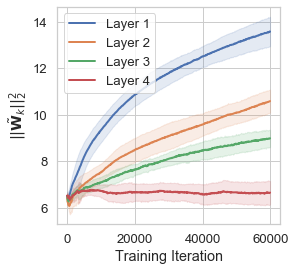

In [333]:
sns.set(rc={'figure.figsize':(4,4), "lines.linewidth":2.0}, style="whitegrid", font_scale=1.2)

plot_multiple_spectral_norms(eq_amp_frames_noise)

[[[ 6.663936   6.8070006  7.0767546 ... 29.898605  29.917046  29.923418 ]
  [ 6.5260143  6.621722   6.793339  ... 16.972013  16.977507  16.983397 ]
  [ 6.669743   6.8374996  7.0660915 ... 18.89543   18.902864  18.914822 ]
  [ 6.544651   7.1730747  7.7908034 ... 22.857742  22.847427  22.86297  ]]

 [[ 6.45847    6.4805646  6.8176994 ... 24.58939   24.608648  24.633207 ]
  [ 6.770225   6.715895   6.859575  ... 15.835696  15.840236  15.833682 ]
  [ 6.3450575  6.443514   6.7015615 ... 12.264257  12.2877035 12.281569 ]
  [ 6.7170753  6.9241548  7.7691674 ... 33.785496  33.775223  33.669716 ]]

 [[ 6.376269   6.4505696  6.8086534 ... 23.43235   23.428692  23.42451  ]
  [ 6.381503   6.1513047  6.359998  ... 14.798624  14.807125  14.830799 ]
  [ 6.646549   6.9101906  7.3756824 ... 15.9825535 15.993113  15.996515 ]
  [ 6.681704   7.332312   8.6655655 ... 28.856045  28.864216  28.902693 ]]

 [[ 6.4384027  6.4263463  6.654022  ... 33.55873   33.55877   33.568104 ]
  [ 6.654351   6.5222836  6.7118

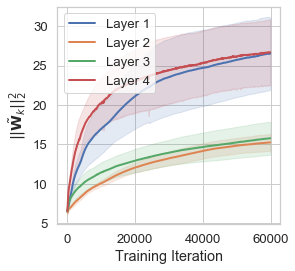

In [335]:
sns.set(rc={'figure.figsize':(4,4), "lines.linewidth":2.0}, style="whitegrid", font_scale=1.2)

plot_multiple_spectral_norms(eq_amp_frames)